In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyscf
from pyscf import gto,dft,scf

In [3]:
# import neuralxc
# from neuralxc.projector.pyscf import get_eri3c as get_mlovlp
import torch
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from net import * 
from torch_routines import * 
from utils import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
from utils import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/sebastian/miniconda3/envs/e3nn/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['eig', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
torch.set_default_dtype(torch.double)

In [5]:
torch.cuda.current_device()
torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.set_default_dtype(torch.double)

In [6]:
!module load cuda10.1

/bin/bash: module: command not found


In [7]:
DEVICE='cuda'

In [104]:
# local = XC_L(device=DEVICE,n_input=3, n_hidden=64, spin_scaling=False)
# local = XC_L(device=DEVICE,n_input=1, n_hidden=16, spin_scaling=True, use=[1])
# local = XC_L(device=DEVICE,n_input=2, n_hidden=16, spin_scaling=True, use=[1, 2],lob=True)
# local = XC_L(device=DEVICE,n_input=2, n_hidden=16, spin_scaling=True, use=[1, 2],lob=False)
# local = XC_L(device=DEVICE,n_input=1, n_hidden=16, spin_scaling=True, use=[1],lob=True)
local = XC_L(device=DEVICE,n_input=2, n_hidden=16, spin_scaling=True, use=[1, 2],lob=True)
# local = XC_L(device=DEVICE,n_input=2, n_hidden=16, spin_scaling=True, use=[1,2],lob=True)
# local = XC_L(device=DEVICE,n_input=2, n_hidden=16, spin_scaling=True, use=[1,2])
# local = C_L(device=DEVICE,n_input=4, n_hidden=16, use=[2,3])
ueg = LDA_X()
xc = XC(grid_models=[local], heg_mult=True, level=3)
xc.epsilon = 0
xc.loge = 1e-3
xc.s_gam = 1

In [105]:
local.load_state_dict(torch.load('revtpss_x_16'))

<All keys matched successfully>

In [106]:
def get_rhos(rho, spin):
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = torch.einsum('ij,ij->j',drho[:,0],drho[:,0]), torch.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = torch.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= torch.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b

In [107]:
def get_data_synth( xc_func ='GGA_X_PBE',n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = np.concatenate([[0],np.exp(np.linspace(-8,4,n))])
#     a_grid =[1000]
    rho = []
    for s in s_grid:
        a_grid = np.concatenate([np.exp(np.linspace(np.log((s/100)+1e-8),8,n))])
        rho.append(get_rho(s, a_grid))
    rho = np.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]/dft.numint.libxc.eval_xc('LDA_X',rho.T, spin=0)[0] -1
 
    rho = torch.from_numpy(rho)
    
    tdrho = xc.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True)
    


    tFxc = torch.from_numpy(fxc)
    return tdrho[0], tFxc

In [122]:
def get_data(mol, xc_func ='GGA_X_PBE',full=False):
    mf = scf.UKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    coords, weights = half_circle(35, 25)
    if not full:
        mf.grids.coords = coords
        mf.grids.weights = weights
    if local.spin_scaling:
        rho_alpha = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_alpha,rho_alpha*0), spin=1)[0] -1
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1
        if mol.spin != 0 and sum(mol.nelec)>1:
            rho = np.concatenate([rho_alpha, rho_beta])
            fxc = np.concatenate([fxc_a, fxc_b])
        else:
            rho = rho_alpha
            fxc = fxc_a
    else:    
        rho_alpha = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
#         fxc = exc/mf._numint.eval_xc('LDA_X',(rho_alpha, rho_beta), spin=1)[0] -1
        fxc = exc
        rho = np.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = torch.from_numpy(mf.make_rdm1())
    ao_eval = torch.from_numpy(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    rho = torch.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)
    
    if dm.ndim == 3:
        rho_filt = (torch.sum(rho[0,0],dim=0) > 1e-8)
    else:
        rho_filt = (rho[0,0] > 1e-8)
    tdrho = xc.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=local.spin_scaling)
    
#     tdrho = torch.from_numpy(tdrho.detach().numpy().round(8))
        
    if local.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            tdrho = torch.cat([tdrho[0],tdrho[1]])
            rho_filt = torch.cat([rho_filt]*2)
            
        else:
            tdrho = tdrho[0]
    tdrho = tdrho[rho_filt]

    tFxc = torch.from_numpy(fxc)[rho_filt]
#     tFxc = torch.from_snumpy(fxc)
    return tdrho, tFxc

In [123]:
spins = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}

selection = [2, 113, 25, 18, 11, 17, 114, 121, 101, 0, 20, 26, 29, 67, 28, 110, 125, 10, 115, 89, 105, 50]
# selection = [28]

atoms = [read('../../haunschild_g2/g2_97.traj',':')[s] for s in selection]
# atoms += [Atoms(a, info={'spin':spins[a]}) for a in np.unique([s for a in atoms for s in a.get_chemical_symbols() ])]
ksr_atoms = atoms

In [124]:
ksr_atoms = ksr_atoms[:]

In [69]:
ksr_atoms = [ksr_atoms[2]]

In [125]:
ksr_atoms = [Atoms('O',info={'spin':2}),Atoms('Cl',info={'spin':1}),Atoms('Al',info={'spin':1}),Atoms('S',info={'spin':2})] + ksr_atoms

In [126]:
def get_mol(atoms, basis='6-311++G**'):
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.M(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.M(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

In [127]:
mols = [get_mol(atoms) for atoms in ksr_atoms]

In [128]:
# mols = [gto.M(atom='H 0 0 -0.37; H 0 0 0.37', basis='6-311++G**'),
#         gto.M(atom='Li 0 0 0', basis='6-311++G**',spin=1),
#         gto.M(atom='N 0 0 0', basis='6-311+G*',spin=3),
#         gto.M(atom='N 0 0 0; O 0 0 1.37', basis='6-311+G*',spin=3),
#         gto.M(atom='Li 0 0 -0.77; F 0 0 0.77', basis='6-311+G*')]
# mols = [gto.M(atom='Li 0 0 -0.77; F 0 0 0.77', basis='6-311+G*')]
# mols = [gto.M(atom='H 0 0 -0.37; H 0 0 0.37', basis='6-311G')]
# mols = [gto.M(atom='Li 0 0 -0.77; F 0 0 0.77', basis='6-311+G*')]

data = [get_data(mol, xc_func='MGGA_X_revTPSS',full=i<10) for i,mol in enumerate(mols)]
# data = [get_data(mol, xc_func='MGGA_C_revTPSS',full=False) for i,mol in enumerate(mols)]
# 
data += [get_data_synth('MGGA_X_revTPSS', 100)]
tdrho = torch.cat([d[0] for d in data]).to(DEVICE)
tFxc = torch.cat([d[1] for d in data]).to(DEVICE)

converged SCF energy = -75.0033804479684  <S^2> = 2.0027444  2S+1 = 3.0018291
converged SCF energy = -459.957577119854  <S^2> = 0.7516194  2S+1 = 2.0016187
converged SCF energy = -242.226560999673  <S^2> = 0.75226413  2S+1 = 2.0022629
converged SCF energy = -397.938786815494  <S^2> = 2.0022329  2S+1 = 3.0014882
converged SCF energy = -1.16580491182897  <S^2> = 1.3322676e-15  2S+1 = 1
converged SCF energy = -109.439263799566  <S^2> = 1.0658141e-14  2S+1 = 1
converged SCF energy = -107.339357395544  <S^2> = 4.2632564e-14  2S+1 = 1
converged SCF energy = -93.3377924464758  <S^2> = 5.2828941e-10  2S+1 = 1
converged SCF energy = -188.456965322797  <S^2> = 3.8582471e-12  2S+1 = 1
converged SCF energy = -920.005608888994  <S^2> = 4.938272e-13  2S+1 = 1
converged SCF energy = -199.394370591257  <S^2> = 1.1191048e-13  2S+1 = 1
converged SCF energy = -150.21489453132  <S^2> = 1.0018599  2S+1 = 2.2377309
converged SCF energy = -77.243504834649  <S^2> = 1.1546319e-14  2S+1 = 1
converged SCF energy

In [129]:
# nan_filt = ~torch.any((tdrho != tdrho),dim=-1)

# tFxc = tFxc[nan_filt]
# tdrho = tdrho[nan_filt,:]

In [130]:
PRINT_EVERY=200
optimizer = torch.optim.Adam(local.parameters(),
                         lr=0.001,weight_decay=0)

eloss = torch.nn.MSELoss()


for epoch in range(100000):
    total_loss = 0
    results = local(tdrho[::])
    loss = eloss(results, tFxc[::])
    total_loss += loss.item()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if epoch%PRINT_EVERY==0:
        print('total loss {:.12f}'.format(total_loss))
        


total loss 0.000079501531
total loss 0.000016831993
total loss 0.000015863903
total loss 0.000015537083
total loss 0.000015365913
total loss 0.000015254968
total loss 0.000015175282
total loss 0.000031096840
total loss 0.000015088303
total loss 0.000015052590
total loss 0.000020714215
total loss 0.000015013949
total loss 0.000014992345
total loss 0.000015674825
total loss 0.000014971052
total loss 0.000014955781
total loss 0.000014958914
total loss 0.000014942108
total loss 0.000014930229
total loss 0.000014933030
total loss 0.000014920570


KeyboardInterrupt: 

In [133]:
drho = tdrho[:,-2].cpu().detach()

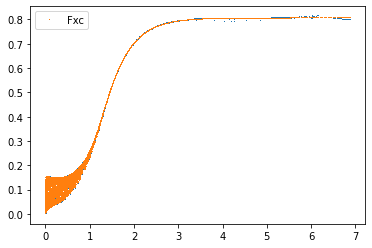

In [134]:
plot(drho, local(tdrho).cpu().detach().data,ls ='',marker=',')
plot(drho, tFxc.cpu(),ls='',marker=',',label='Fxc')
legend()
# xlim(0,3)
# xscale('log')
# yscale('log')

In [135]:
np.log(0.5)

-0.6931471805599453

In [136]:
torch.nn.Tanh()(torch.Tensor([1000]))

tensor([1.])

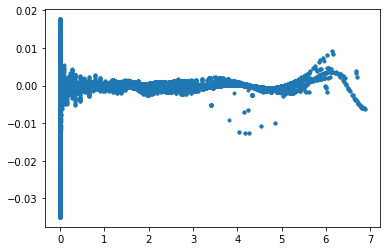

In [137]:
plot(drho, (local(tdrho).cpu()-tFxc.cpu()).detach().data,ls='',marker='.')
# plot(np.exp(drho), Fxc.detach().data)
# xscale('log')

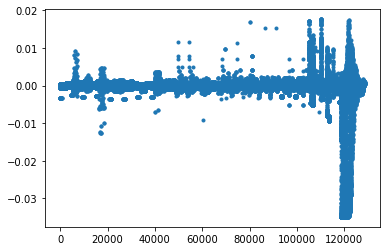

In [138]:
plot((local(tdrho).cpu()-tFxc.cpu()).detach().data,ls='',marker='.')

In [139]:
len(drho)/len(mols)

4944.5

In [140]:
len(mols)

26

In [141]:
torch.save(local.state_dict(), 'revtpss_x_16')

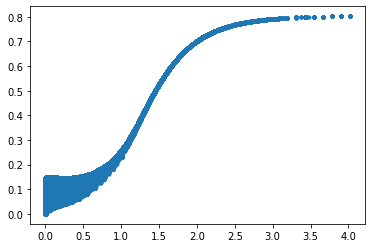

In [259]:
plot(drho, tFxc.cpu().detach().data,ls='',marker='.')

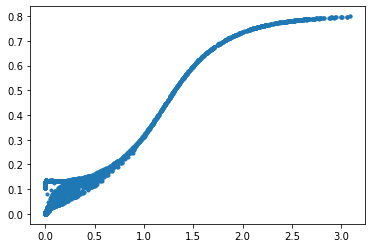

In [60]:
plot(drho, local(tdrho).cpu().detach().data,ls='',marker='.')

In [38]:
x = np.linspace(-10,10,100)

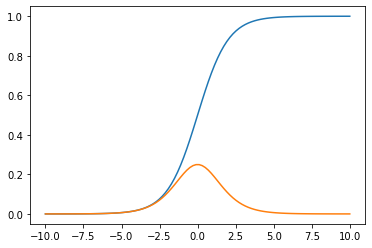

In [41]:
plot(x,np.exp(x)/(1+np.exp(x)))
plot(x,np.exp(x)/(1+np.exp(x))**2)

In [310]:
x = np.linspace(0,1,1000)

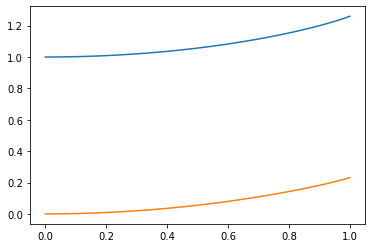

In [312]:
plot(x, 0.5*((1+x)**(4/3) + (1-x)**(4/3)))
plot(x, np.log(0.5*((1+x)**(4/3) + (1-x)**(4/3))))